In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [3]:
s  = ctl.TransferFunction.s
G  = 1/(s**2 + 2*s)
G_bkp = G
G

TransferFunction(array([1]), array([1, 2, 0]))

polos:  (-2+0j) 0j
zeros: 


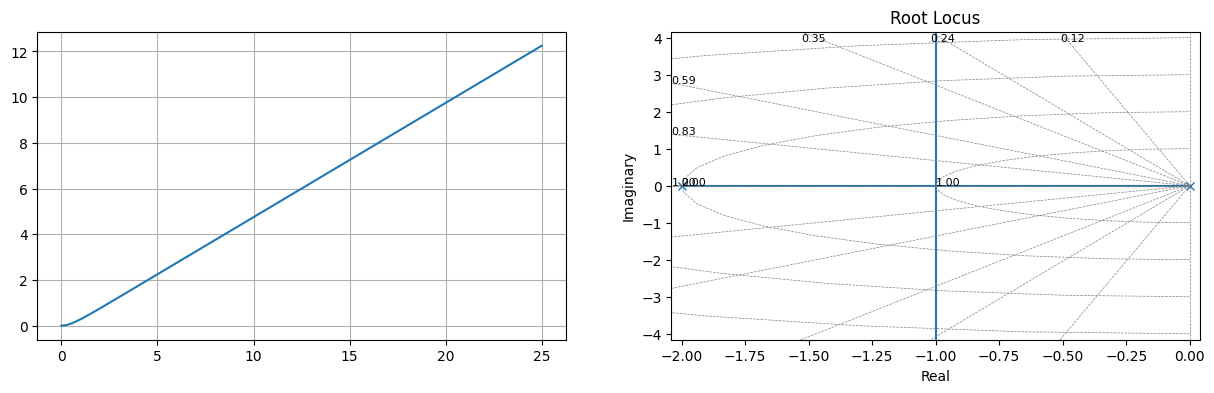

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# REQUISITOS DO SISTEMA
- Os requisitos do sistema serão encontrados a partir do overshoot e tempo de establização máximos permitidos

In [5]:
Ts = 2.0
UP = 0.1

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [6]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.5911550337988976

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [7]:
Wn = 4/(zeta*Ts)
Wn

3.383207256390159

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [8]:
s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)

s_d

-2.0 + 2.729*I

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\frac{s-a}{s-b}$

In [9]:
G = sympyFunction(G)
G

1/(s**2 + 2*s)

In [10]:
angle = sp.arg(G.subs(s, s_d))
angle = float(angle)
angle

2.509145529803499

In [11]:
phi = angle - np.pi
phi

-0.6324471237862941

In [12]:
a = sp.re(s_d) + sp.im(s_d)*np.tan(phi/2)
a = float(a)
a

-2.8929395242607114

In [13]:
b = sp.re(s_d) + sp.im(s_d)*np.tan(3/2*phi)
b = float(b)
b

-5.805489851285513

In [14]:
G_ma = G * (s - a)/(s - b)

K = 1/sp.Abs(G_ma.subs(s, s_d))
K = roundSympyFunction(sp.N(K))
K = float(K)
K

15.058449000120163

# RESPOSTA CONTROLADA

In [15]:
s  = ctl.TransferFunction.s

C = K * (s - a)/(s - b)
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([15.058449  , 43.56318229]), array([ 1.        ,  7.80548985, 11.6109797 ,  0.        ]))

In [16]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([15.058449  , 43.56318229]), array([ 1.        ,  7.80548985, 26.6694287 , 43.56318229]))

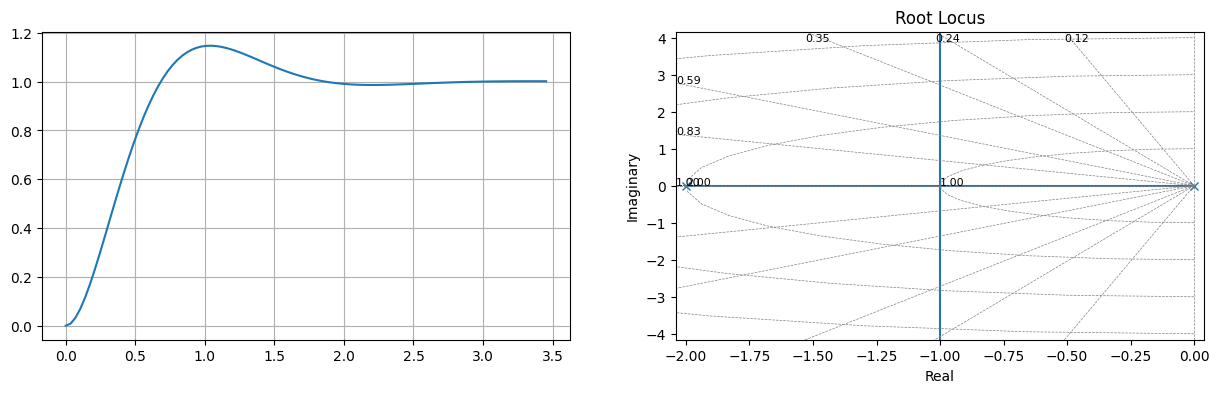

In [17]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

In [18]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.1452568710597285
valor de pico:  1.1467896179972519
tempo de pico:  1.0466284648704212
tempo de assentamento:  1.7443807747840354
valor final:  1.0013383433675496
erro:  0.001338343367549566


# APLICANDO VÁRIOS STEPS

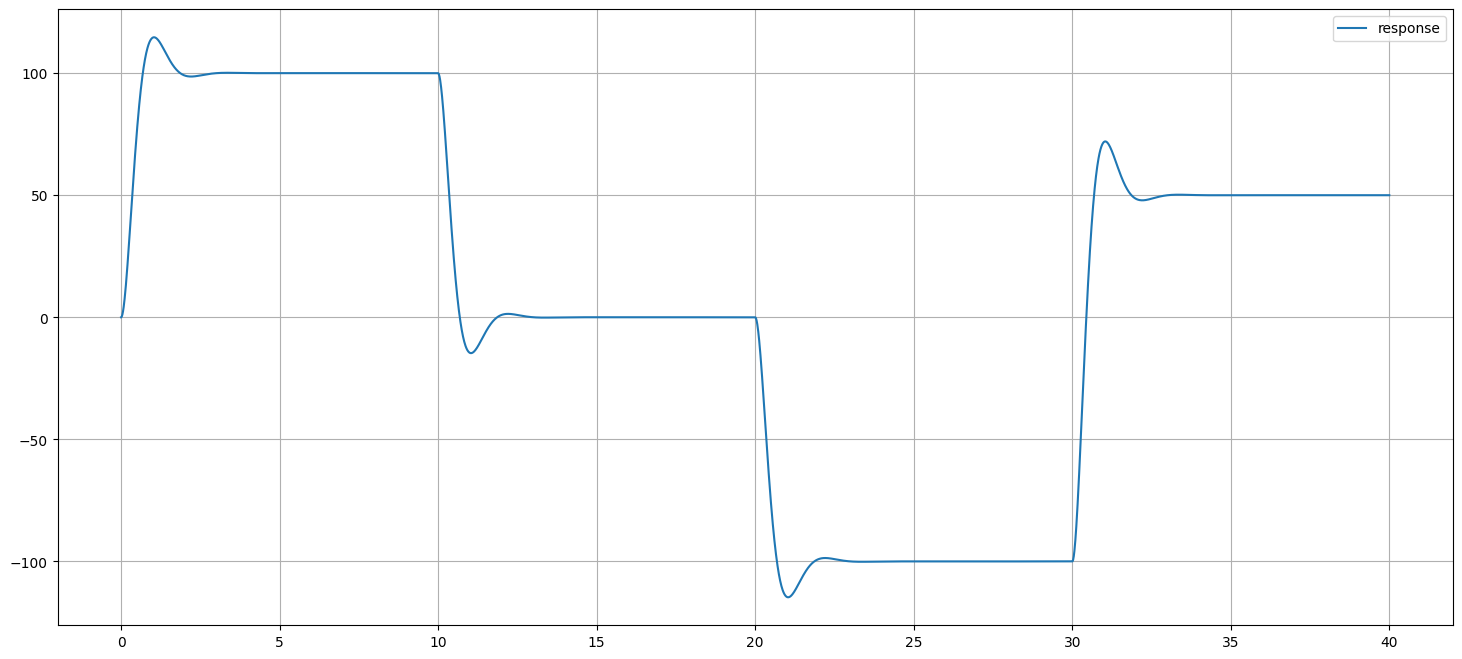

In [19]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()